In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
import altair
import seaborn
RANDOM_SEED = 511
rng = np.random.default_rng(RANDOM_SEED)
seaborn.set_theme(style="darkgrid")
altair.renderers.enable('mimetype')

db_url: str = os.getenv('DB_URL')

In [2]:
# 1 Vet "opioid burden" as directionally correct with deaths
# Agg zip-level opioid burdens and compare to county level opioid deaths

sql = """
with opioid_burden_by_county AS (
    select
        county_name,
        is_nyc,
        sum(population_total) as population,
        sum(opioid_burden) AS opioid_burden,
        sum(opioid_burden_rate_per_100k * population_total)::float 
            / nullif(sum(population_total), 0) as opioid_burden_rate_per_100k
    from ny_zip_opioid_burden_2019
        left join ny_zcta_demographics AS pops using (zip_code)
    group by 1,2
)
, overdose_deaths_by_county as (
    select 
        county_name,
        deaths, 
        total_population,
        rate_per_100k as overdose_rate_per_100k
    from ny_county_od_trend
    where year = '2019'
)
select
    county_name,
    is_nyc,
    op.opioid_burden,
    op.opioid_burden_rate_per_100k,
    od.deaths as overdose_deaths,
    od.overdose_rate_per_100k
from opioid_burden_by_county as op
    full outer join overdose_deaths_by_county as od using (county_name)
"""
county_df = pd.read_sql(sql, con=db_url)
county_df = county_df.set_index('county_name')
county_df.head(3).T

county_name,Albany,Allegany,Broome
is_nyc,False,False,False
opioid_burden,896,22,605
opioid_burden_rate_per_100k,300.379998,45.234556,311.607449
overdose_deaths,49,2,35
overdose_rate_per_100k,16.0,4.3,18.2


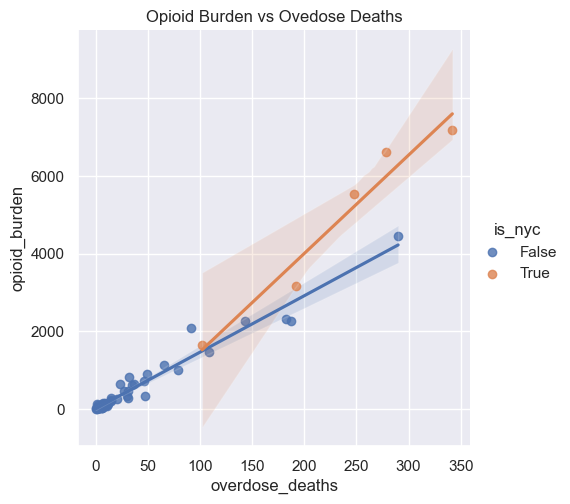

In [3]:
plot = seaborn.lmplot(
    county_df,
    x='overdose_deaths',
    y='opioid_burden',
    hue='is_nyc',
)
plot.set(title='Opioid Burden vs Ovedose Deaths')

In [7]:
county_df[county_df['is_nyc']]

,is_nyc,opioid_burden,opioid_burden_rate_per_100k,overdose_deaths,overdose_rate_per_100k
county_name,,,,,
Bronx,True,7191,484.968684,342,23.9
Kings,True,6610,250.243161,278,10.8
New York,True,5520,338.541373,248,15.2
Queens,True,3152,136.561941,192,8.4
Richmond,True,1639,342.191986,102,21.4


Pretty suggestive. Of course, the relationship may fall apart at the zip code level,
but this is basically enough to work with—opioid burden seems to have something to do with OD
deaths (of course it does!).

This means we can go ahead and figure out if OTP overconcentration is justified by opioid burden stats...

In [4]:
# 1 Vet "opioid burden" as directionally correct with deaths
# Agg zip-level opioid burdens and compare to county level opioid deaths

sql = """
select 
    borough_name,
    year,
    deaths, 
    total_population,
    rate_per_100k as overdose_rate_per_100k
from ny_county_od_trend
where is_nyc
"""
trend_df = pd.read_sql(sql, con=db_url)
trend_df['year'] = pd.to_datetime(trend_df['year'], format='%Y')
trend_df.head(3).T

,0,1,2
borough_name,Bronx,Bronx,Bronx
year,2010-01-01 00:00:00,2011-01-01 00:00:00,2012-01-01 00:00:00
deaths,71,93,109
total_population,1386929,1396954,1411087
overdose_rate_per_100k,5.1,6.7,7.7


In [5]:
(altair.Chart(trend_df)
    .properties(height=500, width=500)
    .mark_line()
    .encode(
        x=altair.X('year', axis=altair.Axis(format='%Y')), 
        y='deaths',   # overdose_rate_per_100k
        color='borough_name'
    )

)

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html
